# Rubric 
1.   Business case and Value
> What hypotheses are you trying to prove?
> *   Data narrative: tell a story to guide an investor or a retiree or just someone interested in buying
2.   Visualizations of data prep
> * Feature importance;
> * Gini score;
> * Shapley value
2.   Data Prep
> 1. Feature Transformation:
>  * Transform features;
>  * Add new features to dataset via amalgamations:
>     * First data set
>     * Second data enrichment [each enrichment enables you to implement / use more algorithms as needed]
>     * Third data enrichment [scrape data from a source and amalgamate]
>  * Compare results with original
>  * Data distribution
> 2. Dimensionality Reduction via PCA
2.   Implement ML algorithms to build models and refine your data narrative
> 1. Define a Golden cluster and use Fractal Clustering to find it based on the business case you formulate
> 1. Train and Apply algorithms
>  * Classify: Muller [at least 5 algos]
>  * Regression: Muller [at least 7 algos]
> 1. Compare relevant tasks in the same table
>  * Write a data narrative to interpret results of each algorithm
2. Suggest Latent Variables or Latent Manifolds
> Add them to the features and see how prediction results change
2. Measuring and compare models
> use appropriate metrics and make comparison in a table:
> * regression metrics and/or classification metrics (confusion matrix, f1)

# Business Case

**The Objective** of the Project is help determine the profitability of the investment

1. Get golden cluster of profitable properties
2. Provide prediction about a property profitability based on a) location(zipcode) b) sqft c) number of bath d) number of beds

Objective Function = Rent - Mortgage Payment - HOA

**City**: Denver

# Prepwork
Import libraries and data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import matplotlib
import re
import types

In [3]:
data = pd.read_csv('/content/gdrive/MyDrive/ML/MidtermProject/Dataset_Realestate.csv')

In [4]:
data.shape

(5890, 22)

In [5]:
data.head(1)

,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,land_area,zestimate,rent_zestimate,days_on_zillow,sold_date,is_zillow_owned,image,listing_type,broker_name,input,property_url,listing_url
0,205,70983496,"109 Sunrise Fls, Cibolo, TX 78108",29.599431,-98.254866,296000.0,USD,3.0,3.0,2294.0 sqft,NaN,270100.0,2024.0,0.0,NaN,False,https://photos.zillowstatic.com/fp/41ca4905859...,House for sale,Opendoor Brokerage LLC,https://www.zillow.com/homes/TX_rb/,https://www.zillow.com/homedetails/109-Sunrise...,https://www.zillow.com/homes/TX_rb/6_p/


## Filter data 

In [6]:
# add new column for the city
def find_city(x):
  city = x.split(', ')[1].lower()
  return city
data['city'] = data['address'].apply(find_city)

In [7]:
# filter all data that belongs to city 'Denver'
denver_data = data[data.city == 'denver']

In [8]:
denver_data.shape

(719, 23)

In [9]:
denver_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719 entries, 11 to 5875
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rank             719 non-null    int64  
 1   property_id      719 non-null    int64  
 2   address          719 non-null    object 
 3   latitude         719 non-null    float64
 4   longitude        719 non-null    float64
 5   price            719 non-null    float64
 6   currency         719 non-null    object 
 7   bathrooms        707 non-null    float64
 8   bedrooms         709 non-null    float64
 9   area             711 non-null    object 
 10  land_area        8 non-null      object 
 11  zestimate        661 non-null    float64
 12  rent_zestimate   683 non-null    float64
 13  days_on_zillow   719 non-null    float64
 14  sold_date        0 non-null      float64
 15  is_zillow_owned  719 non-null    bool   
 16  image            719 non-null    object 
 17  listing_type  

In [10]:
denver_data.iloc[1].property_url

'https://www.zillow.com/homedetails/3485-W-33rd-Ave-Denver-CO-80211/13310709_zpid/'

# Cleaning Data

Reasons to drop columns: 


*   'input', 'listing_url', 'image' - urls are not useful
*   'land_area' - only 8 rows have non-null values
* 'broker_name' - broker agency unlikely to add to a property value
* 'sold_date' - all rows have null values



In [11]:
# drop unnecessary columns
denver_data2 = denver_data.drop(['image', 'broker_name', 'input','listing_url', 'sold_date', 'land_area', 'city'], axis=1)
denver_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719 entries, 11 to 5875
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rank             719 non-null    int64  
 1   property_id      719 non-null    int64  
 2   address          719 non-null    object 
 3   latitude         719 non-null    float64
 4   longitude        719 non-null    float64
 5   price            719 non-null    float64
 6   currency         719 non-null    object 
 7   bathrooms        707 non-null    float64
 8   bedrooms         709 non-null    float64
 9   area             711 non-null    object 
 10  zestimate        661 non-null    float64
 11  rent_zestimate   683 non-null    float64
 12  days_on_zillow   719 non-null    float64
 13  is_zillow_owned  719 non-null    bool   
 14  listing_type     719 non-null    object 
 15  property_url     719 non-null    object 
dtypes: bool(1), float64(8), int64(2), object(5)
memory usage: 90

In [12]:
# example of the data
denver_data2.iloc[1]

rank                                                             253
property_id                                                 13310709
address                            3485 W 33rd Ave, Denver, CO 80211
latitude                                                     39.7641
longitude                                                   -105.034
price                                                         925000
currency                                                         USD
bathrooms                                                          3
bedrooms                                                           3
area                                                     2042.0 sqft
zestimate                                                     961600
rent_zestimate                                                  3694
days_on_zillow                                                     2
is_zillow_owned                                                False
listing_type                      

In [13]:
denver_data2.isnull().sum()

rank                0
property_id         0
address             0
latitude            0
longitude           0
price               0
currency            0
bathrooms          12
bedrooms           10
area                8
zestimate          58
rent_zestimate     36
days_on_zillow      0
is_zillow_owned     0
listing_type        0
property_url        0
dtype: int64

In [14]:
columns = denver_data2.columns.to_list()
for column in columns:
  unique_values = len(denver_data2[column].unique())
  print('{} - {}'.format(column, unique_values))

rank - 719
property_id - 712
address - 712
latitude - 644
longitude - 646
price - 359
currency - 1
bathrooms - 9
bedrooms - 11
area - 610
zestimate - 611
rent_zestimate - 480
days_on_zillow - 37
is_zillow_owned - 2
listing_type - 7
property_url - 712


There are 719 rows in the dataset, but only 712 unique values for the address and property_id

In [15]:
#filter all rows with the same property_id
grouped = denver_data2.groupby('property_id').size()
grouped[grouped > 1]

property_id
13289226     2
13293373     2
13346440     2
13431106     2
63358932     2
63359792     2
247393067    2
dtype: int64

In [16]:
denver_data2[denver_data2.property_id == 63359792]

,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,zestimate,rent_zestimate,days_on_zillow,is_zillow_owned,listing_type,property_url
841,198,63359792,"480 Milwaukee St, Denver, CO 80206",39.72395,-104.951956,1750000.0,USD,4.0,3.0,3597.0 sqft,1688300.0,6441.0,1.0,False,Townhouse for sale,https://www.zillow.com/homedetails/480-Milwauk...
3900,205,63359792,"480 Milwaukee St, Denver, CO 80206",39.72395,-104.951956,1750000.0,USD,4.0,3.0,3597.0 sqft,1688300.0,6441.0,1.0,False,Townhouse for sale,https://www.zillow.com/homedetails/480-Milwauk...


The example illustaretes that rows are different only by rank and index. So we can drop dublicates

In [17]:
denver_data3 = denver_data2.drop_duplicates(['property_id']).copy()
columns = denver_data3.columns.to_list()
for column in columns:
  unique_values = len(denver_data3[column].unique())
  print('{} - {}'.format(column, unique_values))

rank - 712
property_id - 712
address - 712
latitude - 644
longitude - 646
price - 359
currency - 1
bathrooms - 9
bedrooms - 11
area - 610
zestimate - 611
rent_zestimate - 480
days_on_zillow - 37
is_zillow_owned - 2
listing_type - 7
property_url - 712


In [18]:
# drop currency as it's the same for all rows
denver_data3.drop(['currency'],inplace=True, axis=1)

In [19]:
def get_sqrft(s):
  try:
    return float(s)
  except:
    return float(s.split(' ')[0])
denver_data3['area_numeric'] = denver_data3.area.apply(get_sqrft)

In [20]:
denver_data3.drop(['area'],inplace=True, axis=1)

In [21]:
def convert_to_int(owner):
  if owner:
    return 1
  return 0

denver_data3['zillow']=denver_data3.is_zillow_owned.apply(convert_to_int)
denver_data3.price = denver_data3.price.apply(lambda x: int(x))

In [22]:
denver_data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 11 to 5875
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rank             712 non-null    int64  
 1   property_id      712 non-null    int64  
 2   address          712 non-null    object 
 3   latitude         712 non-null    float64
 4   longitude        712 non-null    float64
 5   price            712 non-null    int64  
 6   bathrooms        700 non-null    float64
 7   bedrooms         702 non-null    float64
 8   zestimate        655 non-null    float64
 9   rent_zestimate   676 non-null    float64
 10  days_on_zillow   712 non-null    float64
 11  is_zillow_owned  712 non-null    bool   
 12  listing_type     712 non-null    object 
 13  property_url     712 non-null    object 
 14  area_numeric     704 non-null    float64
 15  zillow           712 non-null    int64  
dtypes: bool(1), float64(8), int64(4), object(3)
memory usage: 89

In [23]:
denver_data3.isnull().sum()

rank                0
property_id         0
address             0
latitude            0
longitude           0
price               0
bathrooms          12
bedrooms           10
zestimate          57
rent_zestimate     36
days_on_zillow      0
is_zillow_owned     0
listing_type        0
property_url        0
area_numeric        8
zillow              0
dtype: int64

In [24]:
denver_data3 = denver_data3.dropna()
denver_data3.isnull().sum()

rank               0
property_id        0
address            0
latitude           0
longitude          0
price              0
bathrooms          0
bedrooms           0
zestimate          0
rent_zestimate     0
days_on_zillow     0
is_zillow_owned    0
listing_type       0
property_url       0
area_numeric       0
zillow             0
dtype: int64

# Visualization of Data Prep

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from yellowbrick.features import FeatureImportances
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pydotplus
from io import StringIO
from sklearn.tree import export_graphviz
from scipy.stats import norm

In [26]:
X = denver_data3.drop(['price','address', 'listing_type', 'listing_type', 'property_url', 'is_zillow_owned'], axis=1)
y = denver_data3.price
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# standardized data
sX = preprocessing.StandardScaler().fit_transform(X)
sX_train, sX_test, sy_train, sy_test = train_test_split(sX,y,test_size=0.2)

### Dummy Regression
Baseline model to compare to

In [27]:
dr = DummyRegressor()
dr.fit(X_train, y_train)
dr.score(X_test, y_test)

-1.3780966527932037e-05

### Linear Regression

In [28]:
lr1 = LinearRegression()
lr2 = LinearRegression()
lr1.fit(X_train, y_train)
lr2.fit(sX_train,sy_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
print('Linear regression score for original data - {}'.format(lr1.score(X_test, y_test)))
print('Linear regression score for standardised data - {}'.format(lr2.score(sX_test, sy_test)))

Linear regression score for original data - 0.9671175251967101
Linear regression score for standardised data - 0.952759998766479


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


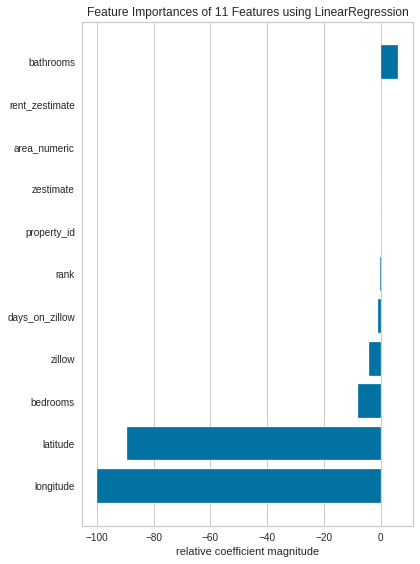

In [30]:
fig, ax = plt.subplots(figsize=(6, 8))
fi_viz = FeatureImportances(lr1, labels=X.columns)
fi_viz.fit(X, y)
fi_viz.poof()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


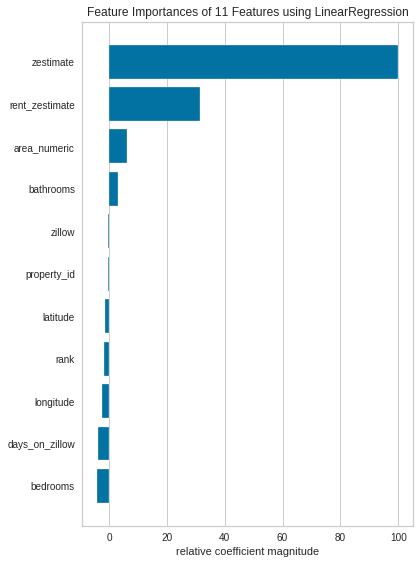

In [31]:
fig, ax = plt.subplots(figsize=(6, 8))
fi_viz = FeatureImportances(lr2, labels=X.columns)
fi_viz.fit(sX, y)
fi_viz.poof()

### Decision Tree Regressor

In [32]:
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(sX_train, sy_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


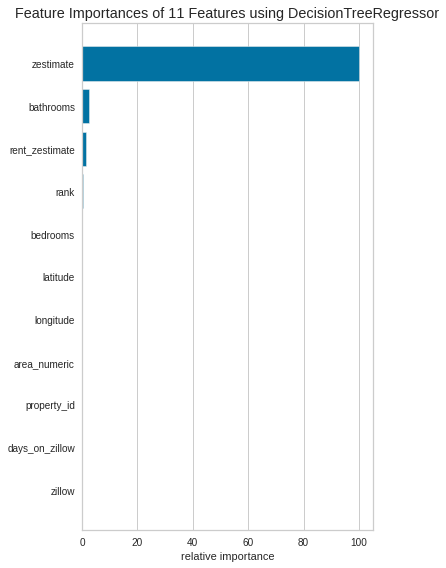

In [33]:
fig, ax = plt.subplots(figsize=(6, 8))
plt.style.use('ggplot')
fi_viz_dtr = FeatureImportances(dtr, labels=X.columns)
fi_viz_dtr.fit(sX, y)
fi_viz_dtr.poof()

### Decision Tree Classifier

In [34]:
dtcl = DecisionTreeClassifier()
dtcl.fit(sX_train, sy_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


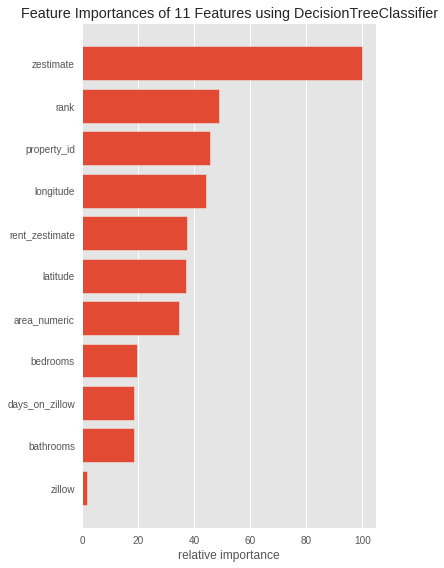

In [35]:
fig, ax = plt.subplots(figsize=(6, 8))
plt.style.use('ggplot')
fi_viz_dtcl = FeatureImportances(dtcl, labels=X.columns)
fi_viz_dtcl.fit(sX, y)
fi_viz_dtcl.poof()

### Random Forest Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


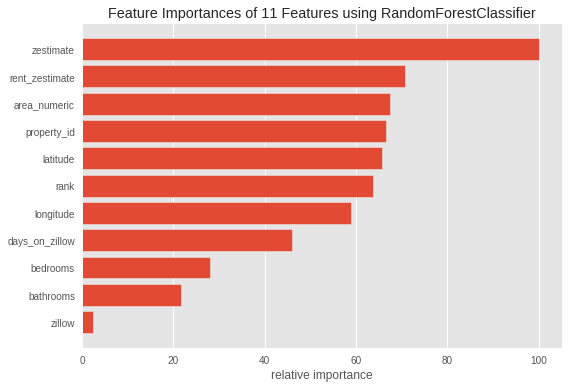

In [36]:
rfc = RandomForestClassifier(n_estimators=10)
viz_rfc = FeatureImportances(rfc, labels=X.columns)
viz_rfc.fit(X, y)
viz_rfc.poof()

### Correlation Matrix

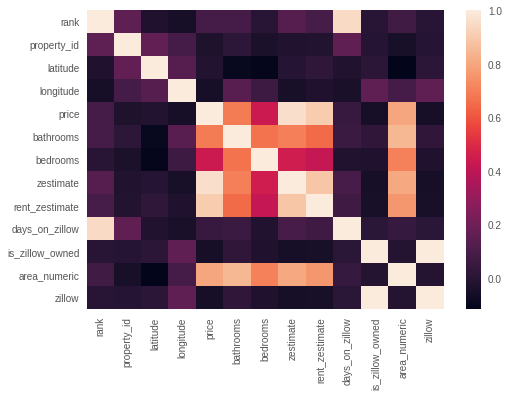

In [37]:
corr = denver_data3.corr()
sns.heatmap(corr)

## SHAP
> Features with large absolute Shapley values are important

In [38]:
!pip install shap
import shap

     |████████████████████████████████| 356 kB 27.5 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491654 sha256=2549a97ff14a09506fb9c55968f268d135e9547b575f3f57a44889d20dcab393
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


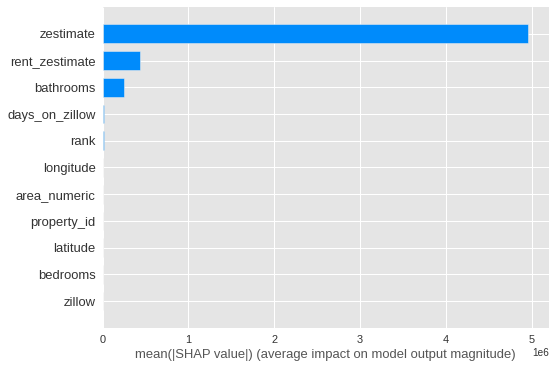

In [39]:
explainer = shap.TreeExplainer(dtr)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

## Factor Plots

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


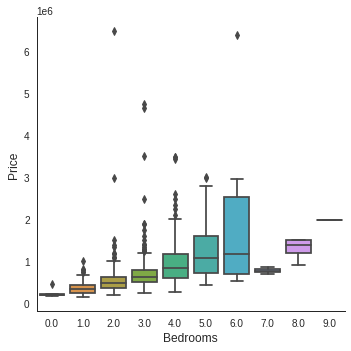

In [40]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bedrooms', 'price', data=denver_data3, kind="box")
  g.set_axis_labels("Bedrooms", "Price")


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


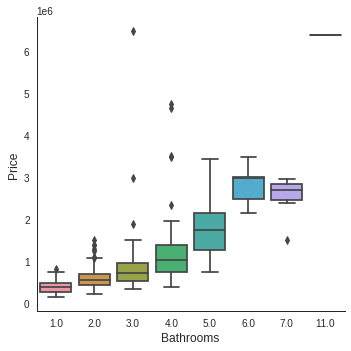

In [41]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bathrooms', 'price', data=denver_data3, kind="box")
  g.set_axis_labels("Bathrooms", "Price")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


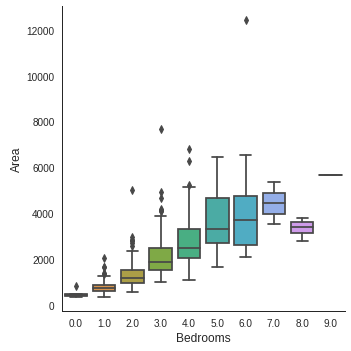

In [42]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bedrooms', 'area_numeric', data=denver_data3, kind="box")
  g.set_axis_labels("Bedrooms", "Area")

# Feature Engineering

### Feature Removal (based on feature importance)

In [43]:
denver_data3.zillow.value_counts(dropna=False)

0    638
1      8
Name: zillow, dtype: int64

> All feature importance plots from the previous section demonstrated that zillow ownership does not affect property price, that's said this feature could be dropped

Rank and Days on Zillow have high correlation. I assume that rank describes the position in the search results for the specific filter. 

Days on Zillow is a timesensitive data - it stands for the number of days the property was listed as for sale at the moment of data scraping. 

> Both features(rank and days_on_zillow) could be removed from the dataset.

Zestimate and Price have high correlation. This feature has the most sugnifficance to predict price, that is logical as it almost always close to the price tag of the property listed.

> Feature 'zestimate' should be removed as well

In [44]:
denver_data4 = denver_data3.drop(['zillow', 'is_zillow_owned', 'rank', 'days_on_zillow', 'zestimate'], axis=1).copy()
denver_data4.columns

Index(['property_id', 'address', 'latitude', 'longitude', 'price', 'bathrooms',
       'bedrooms', 'rent_zestimate', 'listing_type', 'property_url',
       'area_numeric'],
      dtype='object')

In [45]:
denver_data4.shape

(646, 11)

## Feature transformation

### New: price_per_sqft (for outliers detection)

In [46]:
# add price_per_sqrtft
denver_data4['price_per_sqft'] = denver_data4['price']/denver_data4['area_numeric']
denver_data4.price_per_sqft.describe()


count     646.000000
mean      382.021118
std       142.464692
min       147.950521
25%       276.706079
50%       364.402232
75%       455.027662
max      1291.476257
Name: price_per_sqft, dtype: float64

### New: zip_code

In [47]:
def getZipCode(address):
  if not address:
    return None
  zipCode = address.split(' ').pop()
  return int(zipCode)
denver_data4['zip_code'] = denver_data4.address.apply(getZipCode)


### Transform: listing_type

In [48]:
denver_data4.listing_type.value_counts(dropna=False)

House for sale                353
Condo for sale                170
Townhouse for sale             84
Multi-family home for sale     38
Home for sale                   1
Name: listing_type, dtype: int64

Zillow provides 6 types of properties. \
1. Convert Home for sale to House for sale
2. Create one word description of the category
3. Convert column to categorical

In [49]:
def create_category(s):
  word = s.split(' ')[0]
  if (word == 'Home'):
    return 'House';
  return word
denver_data4.listing_type=denver_data4.listing_type.apply(create_category).astype('category')

In [50]:
denver_data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646 entries, 11 to 5875
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   property_id     646 non-null    int64   
 1   address         646 non-null    object  
 2   latitude        646 non-null    float64 
 3   longitude       646 non-null    float64 
 4   price           646 non-null    int64   
 5   bathrooms       646 non-null    float64 
 6   bedrooms        646 non-null    float64 
 7   rent_zestimate  646 non-null    float64 
 8   listing_type    646 non-null    category
 9   property_url    646 non-null    object  
 10  area_numeric    646 non-null    float64 
 11  price_per_sqft  646 non-null    float64 
 12  zip_code        646 non-null    int64   
dtypes: category(1), float64(7), int64(3), object(2)
memory usage: 86.4+ KB


## Outlier Identification and Removal

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


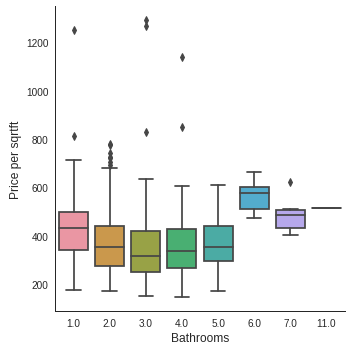

In [51]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bathrooms', 'price_per_sqft', data=denver_data4, kind="box")
  g.set_axis_labels("Bathrooms", "Price per sqrtft")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


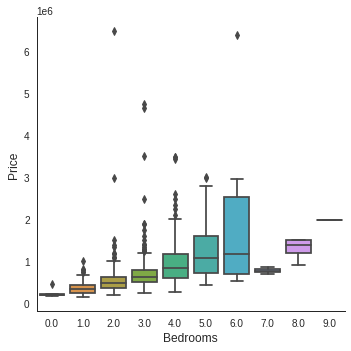

In [52]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bedrooms', 'price', data=denver_data4, kind="box")
  g.set_axis_labels("Bedrooms", "Price")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


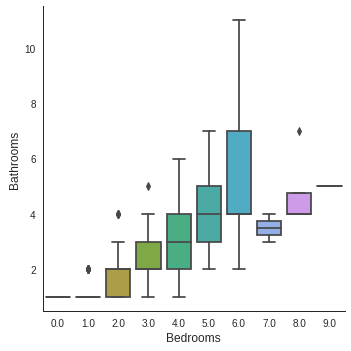

In [53]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bedrooms', 'bathrooms', data=denver_data4, kind="box")
  g.set_axis_labels("Bedrooms", "Bathrooms")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


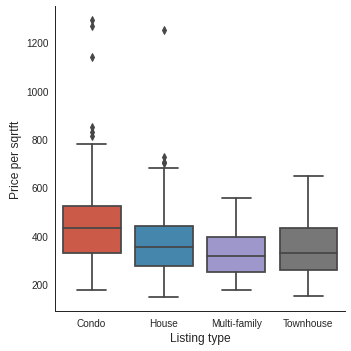

In [54]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('listing_type', 'price_per_sqft', data=denver_data4, kind="box")
  g.set_axis_labels( "Listing type", "Price per sqrtft")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


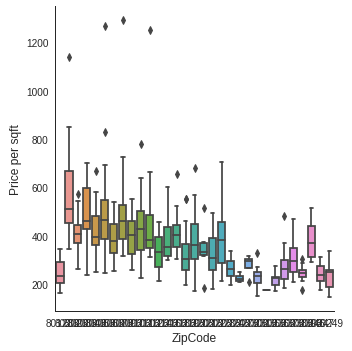

In [55]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('zip_code', 'price_per_sqft', data=denver_data4, kind="box")
  g.set_axis_labels( "ZipCode", "Price per sqft")

1. Remove outliers in each zipcode per the price_per_sqft


In [56]:
# based of function by https://github.com/dhavalsays
# for outlier identification instead of 1 standart deviation I used 2 standart deviations
def remove_outliers(df, group_column, feature):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby(group_column):
        m = np.mean(subdf[feature])
        st = np.std(subdf[feature])
        reduced_df = subdf[(subdf[feature]>(m-(2 * st))) & (subdf[feature]<=(m+(2 *st)))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
denver_data5 = remove_outliers(denver_data4, 'zip_code', 'price_per_sqft')
denver_data4.shape

(646, 13)

In [57]:
denver_data5.shape

(624, 13)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


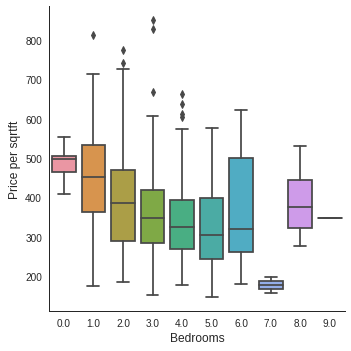

In [58]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bedrooms', 'price_per_sqft', data=denver_data5, kind="box")
  g.set_axis_labels("Bedrooms", "Price per sqrtft")

2. Remove outliers in each bedrooms quantity per the price_per_sqft

In [ ]:
denver_data6 = remove_outliers(denver_data5, 'bedrooms', 'price_per_sqft')
denver_data6.shape

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


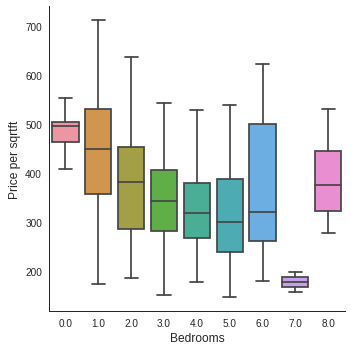

In [61]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bedrooms', 'price_per_sqft', data=denver_data6, kind="box")
  g.set_axis_labels("Bedrooms", "Price per sqrtft")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


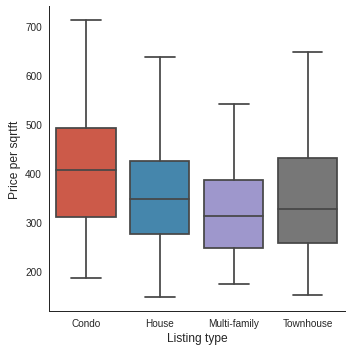

In [62]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('listing_type', 'price_per_sqft', data=denver_data6, kind="box")
  g.set_axis_labels( "Listing type", "Price per sqrtft")

## Data Enrichment 

3 properties will be scraped from zillow.com: a) elementary school rating, b) hoa fees, c) lot sqft

In [63]:
import requests
from bs4 import BeautifulSoup
req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
}

In [64]:
def get_hoa(row):
  page = requests.get(row['property_url'], headers=req_headers)
  if page.status_code != 200:
    return 0, 0, np.nan
  soup = BeautifulSoup(page.text, 'html.parser')
  # get hoa data
  # alternative version: 
  # hoa_h5 = soup.find('h5', text="HOA and financial details")
  # hoa_span = hoa_h5.parent.select_one('div div ul li span') if hoa_h5 else np.nan
  # hoa = hoa_span.getText() if hoa_span else np.nan
  hoa_sibling_span = soup.find('span', text="HOA:")
  hoa_span = hoa_sibling_span.find_next_sibling('span') if hoa_sibling_span else None
  hoa = hoa_span.getText() if hoa_span else 0

  #get lot area data
  lot_sibling_span = soup.find('span', text="Lot:")
  lot_span = lot_sibling_span.find_next_sibling('span') if lot_sibling_span else None
  lot_area = lot_span.getText() if lot_span else 0

  #get school rating
  elementary_school_span = soup.select_one('ul#ds-nearby-schools-list li div div span')
  elementary_school = elementary_school_span.getText() if elementary_school_span else np.nan
 
  return hoa, lot_area, elementary_school

In [ ]:
denver_data6['hoa'], denver_data6['lot_area'], denver_data6['school'] = zip(*denver_data6.apply(get_hoa, axis=1))


### New: hoa fees

In [66]:
denver_data6.hoa.unique()

array(['$249 monthly', '$235 monthly', '$166 monthly', '$367 monthly',
       '$303 monthly', '$327 monthly', '$380 monthly', '$482 monthly',
       '$6,078 annually', '$452 monthly', '$514 monthly', '$518 monthly',
       '$424 monthly', '$448 monthly', '$581 monthly', '$446 monthly',
       '$707 monthly', '$445 monthly', '$488 monthly', '$790 monthly',
       '$576 monthly', '$245 monthly', '$316 monthly', '$361 monthly',
       '$428 monthly', '$225 monthly', '$606 monthly', '$399 monthly', 0,
       '$533 monthly', '$548 monthly', '$258 monthly', '$398 monthly',
       '$336 monthly', '$293 monthly', '$343 monthly', '$416 monthly',
       '$224 monthly', '$1,447 monthly', '$356 monthly', '$262 monthly',
       '$320 monthly', '$300 monthly', '$200 monthly', '$275 monthly',
       '$358 monthly', '$212 monthly', '$227 monthly', '$290 monthly',
       '$291 monthly', '$353 monthly', '$248 monthly', '$250 monthly',
       '$257 monthly', '$260 monthly', '$325 monthly', '$289 monthly'

HOA values are strings. 
To use it I will: 
1. get number
2. get payment frequency

In [67]:
def parse_hoa(row):
  if row.hoa == 0 or row.hoa == 'No Data':
    return 0, ""
  s = row.hoa.split(' ');
  num = re.findall('[0-9]+', s[0])
  return int(''.join(num)), s[1]
denver_data6['hoa_amount'], denver_data6['hoa_period'] = zip(*denver_data6.apply(parse_hoa, axis=1))


In [68]:
denver_data6.hoa_period.unique()

array(['monthly', 'annually', '', 'quarterly'], dtype=object)

In [69]:
def parse_period(period):
  if period == 'monthly':
    return 1
  if period == 'annually':
    return 1/12
  if period == 'quaterly':
    return 1/4
  return 0

denver_data6.hoa_period = denver_data6.hoa_period.apply(parse_period)

In [70]:
denver_data6.isnull().sum()

property_id       0
address           0
latitude          0
longitude         0
price             0
bathrooms         0
bedrooms          0
rent_zestimate    0
listing_type      0
property_url      0
area_numeric      0
price_per_sqft    0
zip_code          0
hoa               0
lot_area          0
school            4
hoa_amount        0
hoa_period        0
dtype: int64

In [74]:
denver_data6.dropna(inplace=True)
denver_data6.shape

(597, 18)

### New: lot_area

In [155]:
denver_data6.lot_area.unique()

array([0, '0.48 Acres', '2,350 sqft', '1,230 sqft', '2,256 sqft',
       '3,683 sqft', 'No Data', '435.60 sqft', '8,120 sqft', '2,770 sqft',
       '6,260 sqft', '1.17 Acres', '5,950 sqft', '2,419 sqft',
       '6,030 sqft', '3,100 sqft', '646 sqft', '3,002 sqft', '3,049 sqft',
       '4,630 sqft', '3,140 sqft', '8,280 sqft', '4,356 sqft',
       '7,500 sqft', '6,098 sqft', '1,825 sqft', '2,990 sqft',
       '6,250 sqft', '4,687 sqft', '6,870 sqft', '1,133 sqft',
       '1,819 sqft', '991 sqft', '1,255 sqft', '3,750 sqft', '1,406 sqft',
       '4,370 sqft', '6,491 sqft', '9,209 sqft', '8,050 sqft',
       '6,350 sqft', '6,000 sqft', '6,240 sqft', '2,372 sqft',
       '6,110 sqft', '6,100 sqft', '9,370 sqft', '6,500 sqft',
       '7,470 sqft', '830 sqft', '2,549 sqft', '7,800 sqft', '522 sqft',
       '644 sqft', '2,457 sqft', '1,260 sqft', '1,464 sqft', '2,088 sqft',
       '3,316 sqft', '6,300 sqft', '0.26 Acres', '8,500 sqft',
       '4,500 sqft', '0.47 Acres', '1,108 sqft', '4,690 s

In [158]:
def parse_lot(row):
  if row.lot_area == 0 or row.lot_area == 'No Data':
    return 0, ""
  s = row.lot_area.split(' ');
  num = re.findall('[0-9]+', s[0])
  return int(''.join(num)), s[1]
denver_data6.lot_area, denver_data6['lot_unit'] = zip(*denver_data6.apply(parse_lot, axis=1))

In [159]:
denver_data6.lot_unit.unique()

array(['', 'Acres', 'sqft'], dtype=object)

In [163]:
def lot_multiplier(unit):
  if (unit == '' or unit == 'sqft'):
    return 1
  return 43560

denver_data6['lot_multiplier'] = denver_data6.lot_unit.apply(lot_multiplier)
denver_data6.lot_area = denver_data6.lot_area * denver_data6.lot_multiplier

In [167]:
denver_data6.lot_area.describe()

count    5.970000e+02
mean     2.828733e+09
std      1.614728e+10
min      0.000000e+00
25%      0.000000e+00
50%      3.800000e+03
75%      6.250000e+03
max      2.220044e+11
Name: lot_area, dtype: float64

### New: school rating

In [168]:
denver_data6.school= denver_data6.school.astype('category')

### New: mortgage payment

In [169]:
!pip install numpy-financial
import numpy_financial as npf

Assume the interest is 2.9% (actual market Wellsfargo);
The mortgage is taken for 30 years with 10% downpayment

In [170]:
interest = 0.029
years = 30
payments_year = 12

denver_data6['mortgage_amount'] = denver_data6.price.apply(lambda x: -1 * npf.pmt(interest/12, years * 12, 0.9* x))

### New: profit
Profit = Rent - monthly_hoa - mortgage payment

In [171]:
denver_data6['profit'] = denver_data6.rent_zestimate - denver_data6.hoa_amount * denver_data6.hoa_period - denver_data6.mortgage_amount

### New: ROI
roi = profit / cost \
in our case: roi = profit/(rent - profit)

In [172]:
denver_data6['roi']=denver_data6.profit/( denver_data6.rent_zestimate - denver_data6.profit)

## Visualization

In [173]:
# inspired by Kaggle EDA & Auto ML - House Prices 
def categorial_feature_overview(df, feature, rotation=0):
    print(feature.upper())
    f,ax = plt.subplots(1, 2, figsize=(20, 6))
    ax[0].tick_params(labelrotation=rotation)
    ax[1].tick_params(labelrotation=rotation)
    sns.boxplot(data=df, x=feature, y='roi', ax=ax[1])
    sns.countplot(data=df, x=feature, ax=ax[0]);
    plt.show()
    
def numerical_feature_overview(df, feature, rotation=0):
    print(feature.upper())
    f,ax = plt.subplots(1, 2, figsize=(20, 6))
    ax[0].tick_params(labelrotation=rotation)
    ax[1].tick_params(labelrotation=rotation)
    sns.scatterplot(data=df, x=feature, y='roi', ax=ax[0]);
    sns.boxplot(data=df, x=feature, ax=ax[1])
    plt.show()

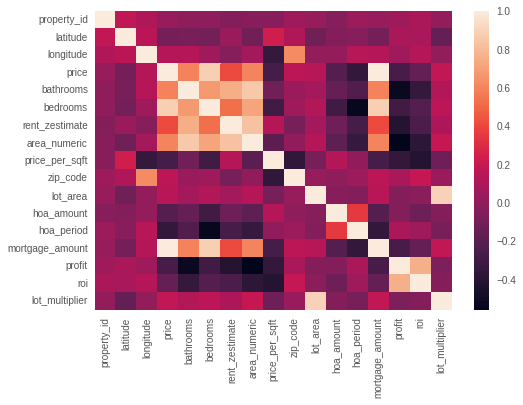

In [174]:
corr = denver_data6.corr()
sns.heatmap(corr)

LISTING_TYPE


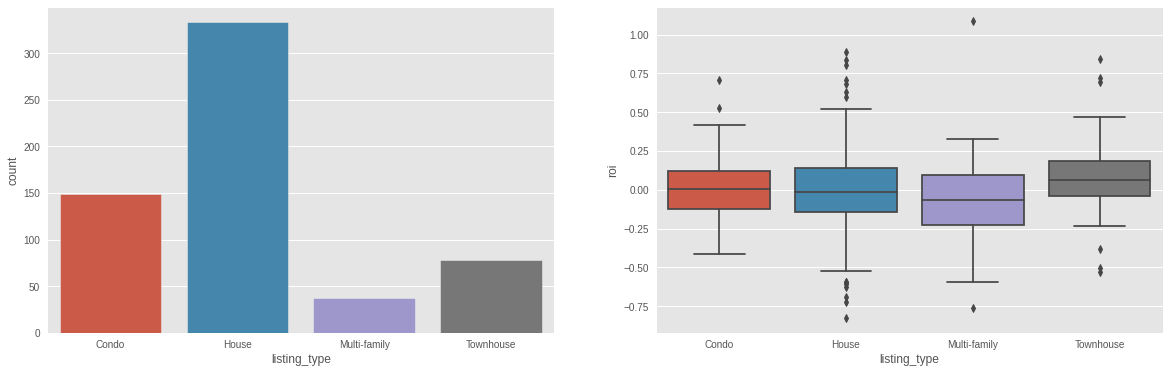

In [175]:
categorial_feature_overview(denver_data6, 'listing_type')

ZIP_CODE


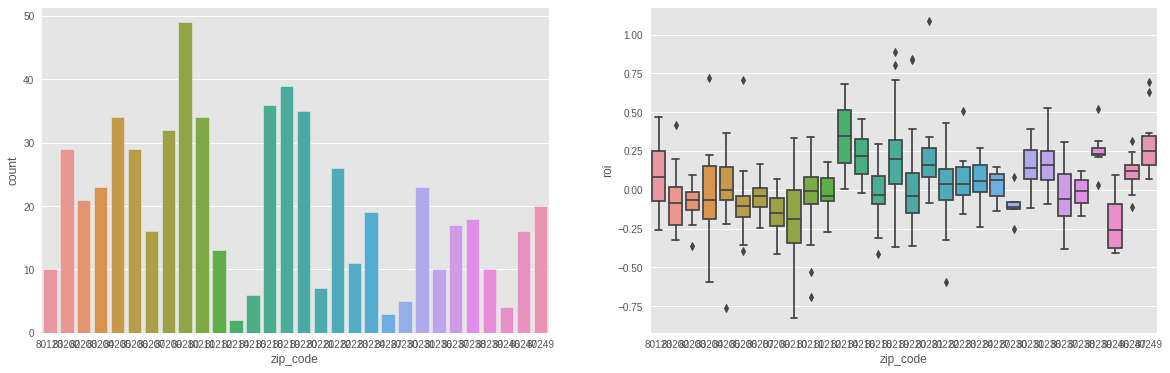

In [188]:
categorial_feature_overview(denver_data6, 'zip_code')

SCHOOL


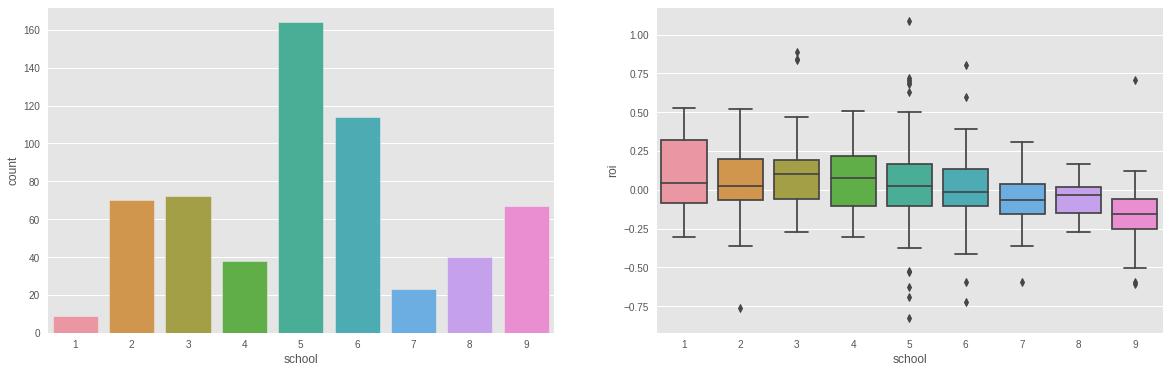

In [176]:
categorial_feature_overview(denver_data6, 'school')

BATHROOMS


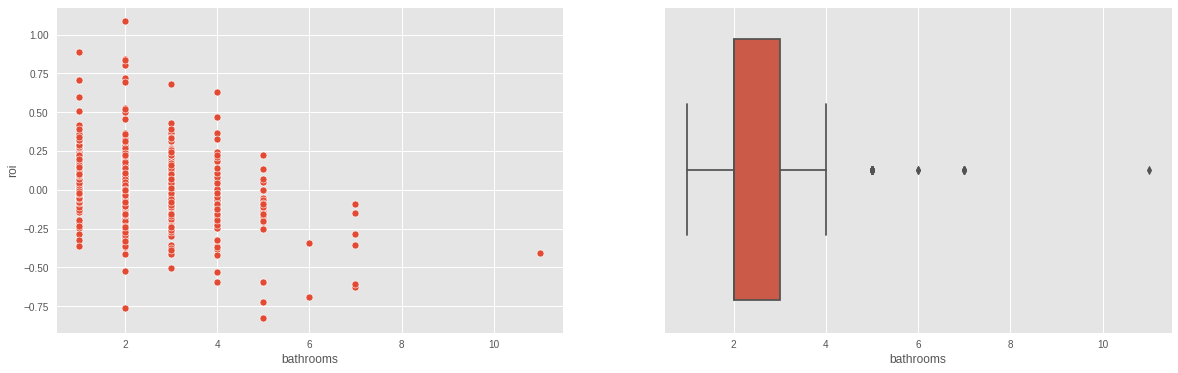

In [177]:
 numerical_feature_overview(denver_data6, 'bathrooms')

BEDROOMS


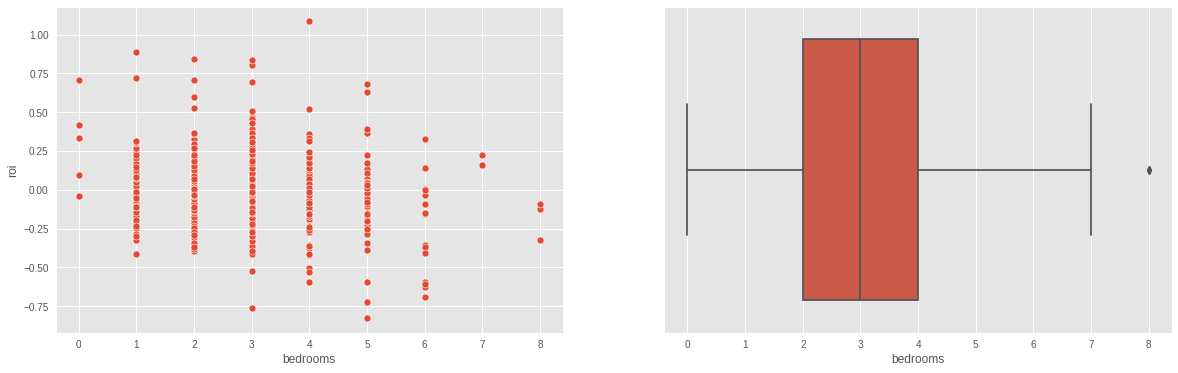

In [178]:
numerical_feature_overview(denver_data6, 'bedrooms')

AREA_NUMERIC


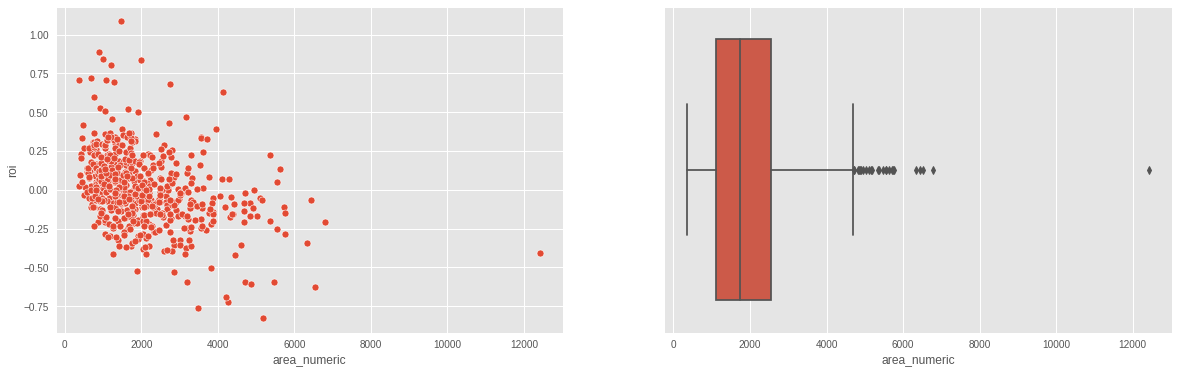

In [179]:
numerical_feature_overview(denver_data6, 'area_numeric')

LOT_AREA


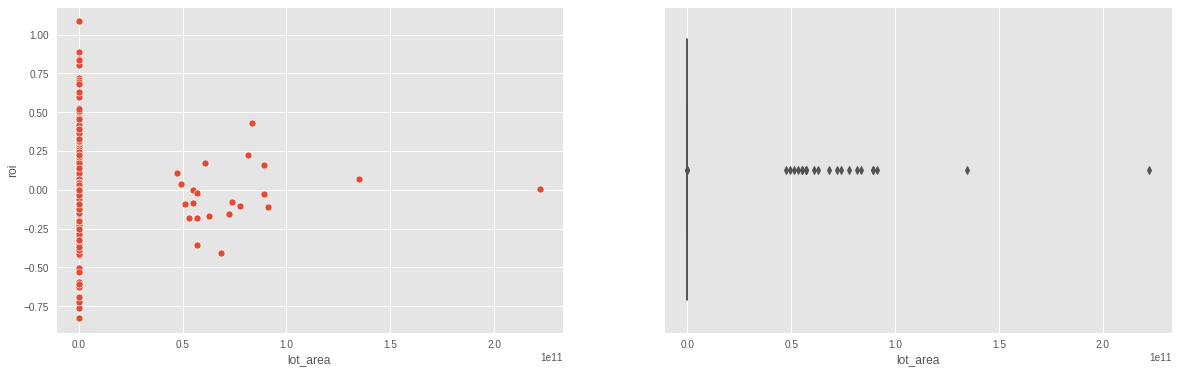

In [180]:
numerical_feature_overview(denver_data6, 'lot_area')

# PCA and updated Feature Selection

Roi is a derivative value all precursors such as 'mortgage_amount', 'hoa_amount', 'rent_zestimate', 'price', 'profit' will be removed

In [244]:
denver_data7 = denver_data6.drop(['address', 'property_url', 'property_id', 'hoa', 'hoa_period', 'lot_unit', 'lot_multiplier', 'mortgage_amount', 'hoa_amount', 'rent_zestimate', 'price', 'profit'], axis=1).copy()

In [245]:
denver_data7.zip_code = denver_data7.zip_code.astype('category')

In [246]:
denver_data7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 600
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   latitude        597 non-null    float64 
 1   longitude       597 non-null    float64 
 2   bathrooms       597 non-null    float64 
 3   bedrooms        597 non-null    float64 
 4   listing_type    597 non-null    category
 5   area_numeric    597 non-null    float64 
 6   price_per_sqft  597 non-null    float64 
 7   zip_code        597 non-null    category
 8   lot_area        597 non-null    int64   
 9   school          597 non-null    category
 10  roi             597 non-null    float64 
dtypes: category(3), float64(7), int64(1)
memory usage: 65.8 KB


3 of 15 columns are categorical data (school, listing_type and zip_code)

For PCA categorical data will be excluded

In [247]:
from sklearn.decomposition import PCA
from yellowbrick.features.pca import (PCADecomposition)

In [422]:
X = denver_data7.drop(['roi', 'school', 'listing_type', 'zip_code'], axis=1)
y = denver_data7.roi
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# standardized data
sX = preprocessing.StandardScaler().fit_transform(X)
sX_train, sX_test, sy_train, sy_test = train_test_split(sX,y,test_size=0.2)

### PCA

In [433]:
pca = PCA(random_state=42)
X_pca = pca.fit_transform(sX)
pca.explained_variance_ratio_

array([0.37953143, 0.17921645, 0.16814392, 0.1331933 , 0.07896708,
       0.04199902, 0.0189488 ])

[(0.0, 1.0),
 Text(0, 0.5, 'Percent of Explained variance'),
 Text(0.5, 0, 'Component'),
 Text(0.5, 1.0, 'Cumulative Variance')]

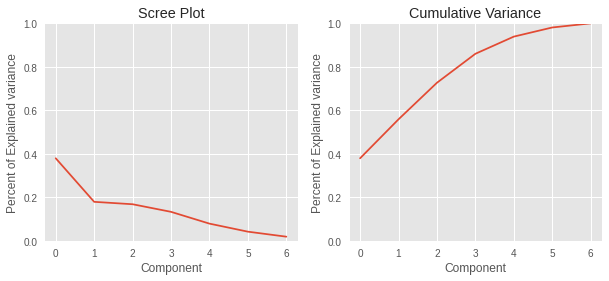

In [434]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(pca.explained_variance_ratio_)
ax[0].set(xlabel="Component",ylabel="Percent of Explained variance",title="Scree Plot",ylim=(0, 1),)
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set(xlabel="Component",ylabel="Percent of Explained variance",title="Cumulative Variance",ylim=(0, 1),)

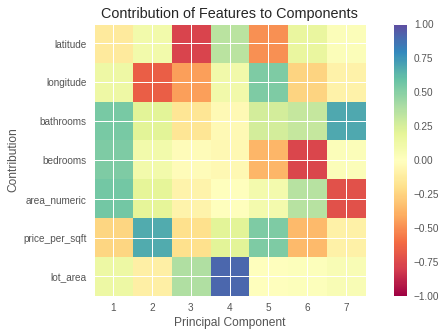

In [435]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.imshow(pca.components_.T,cmap="Spectral",vmin=-1,vmax=1,)
plt.yticks(range(len(X.columns)), X.columns)
plt.xticks(range(7), range(1, 8))
plt.xlabel("Principal Component")
plt.ylabel("Contribution")
plt.title("Contribution of Features to Components")
plt.colorbar()

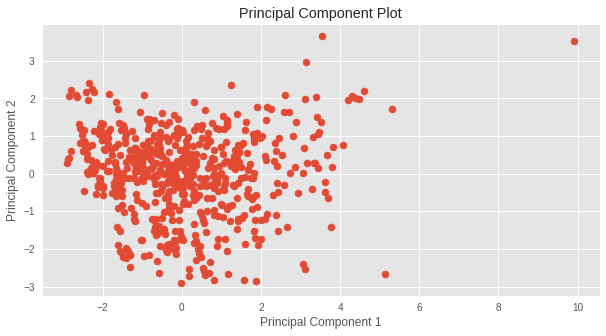

In [436]:
fig, ax = plt.subplots(figsize=(10, 5))
pca_viz = PCADecomposition()
pca_viz.fit_transform(sX, y)
pca_viz.poof()


### Feature Selection using  SelectKBest

In [379]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [406]:
X = denver_data7.drop(['roi', 'latitude', 'longitude'], axis=1)
y = denver_data7.roi

listing_types = X.listing_type.unique().to_list()
encoder = OrdinalEncoder(categories=[listing_types])
X.listing_type = encoder.fit_transform(X[['listing_type']])
X.school = X.school.cat.codes
X.zip_code = X.zip_code.cat.codes

In [410]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

In [408]:
# based on solution by Jason Brownlee
# score_function was updated to mutual_info_regression instead of mutual_info_classif as y is continuous target
 
# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=mutual_info_regression, k='all')
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 

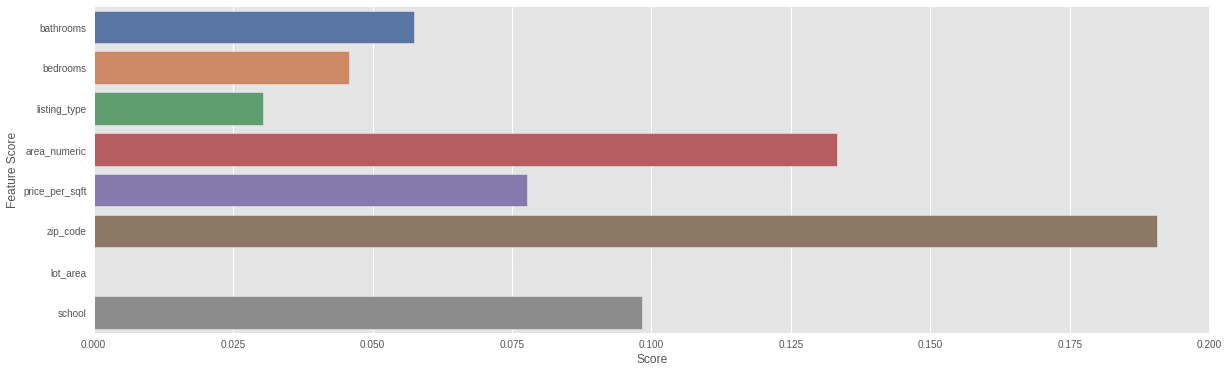

In [411]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
columns = X.columns.to_list()
df = pd.DataFrame(columns=['Name', 'Score'])
for i in range(len(fs.scores_)):
  df = df.append({'Name': columns[i], 'Score': fs.scores_[i]}, ignore_index=True)

f = plt.subplots(figsize=(20, 6))
ax = sns.barplot(x='Score', y='Name', data=df, palette="deep")
ax.set_ylabel("Feature Score")

# Finalize the plot
sns.despine(bottom=False)
plt.show()

## Results of Feature Selection

PCA analysis identified that 4 non-categorical features are enough to predict 80% and we see that school and zipcode are showing hight feature importance.



In [449]:
denver_data8 = denver_data7.drop(['lot_area', 'latitude', 'longitude'], axis=1).copy()
denver_data8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 600
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   bathrooms       597 non-null    float64 
 1   bedrooms        597 non-null    float64 
 2   listing_type    597 non-null    category
 3   area_numeric    597 non-null    float64 
 4   price_per_sqft  597 non-null    float64 
 5   zip_code        597 non-null    category
 6   school          597 non-null    category
 7   roi             597 non-null    float64 
dtypes: category(3), float64(5)
memory usage: 51.8 KB


# Golden Cluster

In [455]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [452]:
def plot_cluster(df,features, max_loop=50 ):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df[features]
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

In [453]:
def apply_cluster(df, features, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df[features]
    kmeans = KMeans(n_clusters=clusters)  
    kmeans.fit(X) 
    score = metrics.silhouette_score(X, kmeans.labels_, random_state=10)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans.predict(X), s=50, cmap='viridis')
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df

In [493]:
denver_data_cluster = denver_data8.copy()
denver_data_cluster.school = denver_data_cluster.school.astype('int')
denver_data_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 600
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   bathrooms       597 non-null    float64 
 1   bedrooms        597 non-null    float64 
 2   listing_type    597 non-null    category
 3   area_numeric    597 non-null    float64 
 4   price_per_sqft  597 non-null    float64 
 5   zip_code        597 non-null    category
 6   school          597 non-null    int64   
 7   roi             597 non-null    float64 
dtypes: category(2), float64(5), int64(1)
memory usage: 55.5 KB


In [517]:
features = ['roi', 'area_numeric']

### Iteration 1

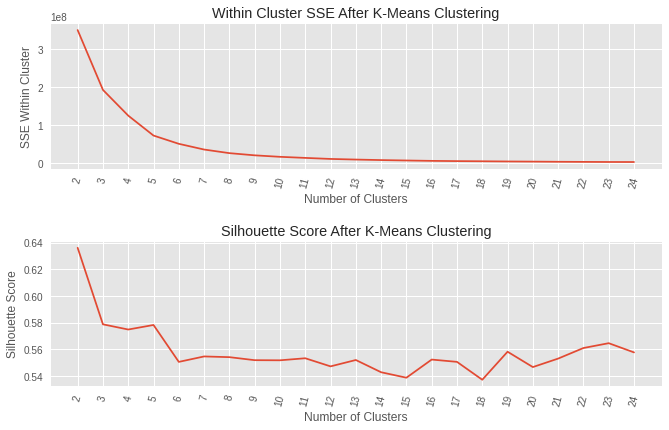

In [518]:
plot_cluster(denver_data_cluster, features, max_loop=25)

clustering performance
-----------------------------------
silhouette score: 0.55
sse withing cluster: 49994941.0


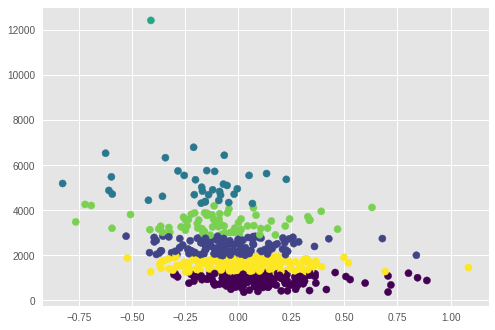

In [519]:
first_iteration = apply_cluster(denver_data_cluster, features,6)

In [520]:
first_iteration

,bathrooms,bedrooms,listing_type,area_numeric,price_per_sqft,zip_code,school,roi,cluster
0,1.0,0.0,Condo,485.0,463.917526,80202,5,0.415416,0
1,1.0,0.0,Condo,402.0,497.512438,80203,6,0.093249,0
2,1.0,0.0,Condo,374.0,505.347594,80206,9,0.705724,0
3,1.0,0.0,Condo,828.0,554.347826,80206,7,-0.039296,0
4,1.0,0.0,Condo,440.0,409.090909,80210,5,0.336230,0
...,...,...,...,...,...,...,...,...,...
596,4.0,7.0,House,5369.0,158.316260,80249,5,0.226697,2
597,4.0,8.0,House,3799.0,336.930771,80203,6,-0.122518,4
598,4.0,8.0,Multi-family,2819.0,532.103583,80209,5,-0.326174,1
599,7.0,8.0,House,3596.0,417.130145,80218,6,-0.089606,4


In [521]:
cluster_perf_df = (
    first_iteration
    .groupby('cluster')
    .agg({"roi":"mean", "zip_code": "count", "area_numeric":"mean", "school":"mean"})
    .sort_values('roi')
    .reset_index()
)

cluster_perf_df

,cluster,roi,zip_code,area_numeric,school
0,3,-0.410557,1,12416.000000,9.000000
1,2,-0.196952,35,5136.942857,6.800000
2,4,-0.095983,76,3416.276316,5.868421
3,1,-0.045530,136,2360.676471,5.411765
4,5,0.031630,172,1588.424419,4.819767
5,0,0.111664,177,893.203390,4.785311


In [522]:
medium_sub = denver_data_cluster.query("roi > -0.05").reset_index(drop=True)
medium_sub.shape

(357, 9)

### Iteration 2

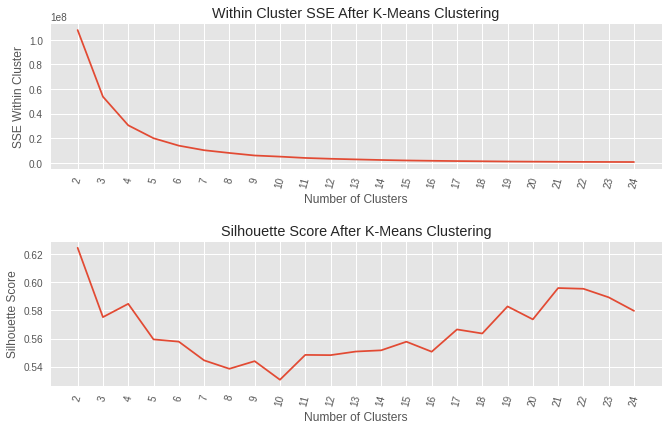

In [523]:
plot_cluster(medium_sub, features, max_loop=25)

clustering performance
-----------------------------------
silhouette score: 0.55
sse withing cluster: 5932009.0


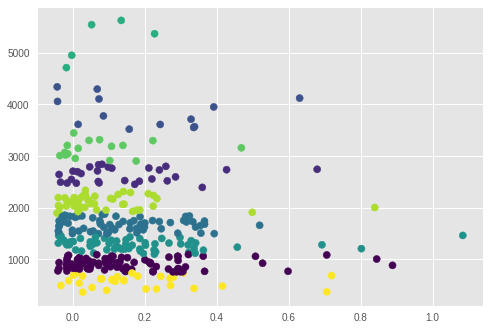

In [524]:
second_iteration = apply_cluster(medium_sub, features, 9)

In [525]:
cluster_perf_df = (
    second_iteration
    .groupby('cluster')
    .agg({"roi":"mean", "bathrooms":"mean", "zip_code": "count", "bedrooms":"mean", "area_numeric":"mean", "school":"mean"})
    .sort_values('roi')
    .reset_index()
)

cluster_perf_df

,cluster,roi,bathrooms,zip_code,bedrooms,area_numeric,school
0,6,0.071852,3.529412,17,4.235294,3133.235294,6.411765
1,5,0.077972,4.600000,5,5.000000,5241.000000,7.000000
2,7,0.089100,2.434783,46,3.630435,2097.782609,4.695652
3,3,0.137729,2.268657,67,2.880597,1677.850746,4.417910
4,1,0.142910,2.821429,28,3.642857,2635.607143,5.035714
5,0,0.162712,1.325581,86,1.790698,912.290698,4.651163
6,4,0.169856,1.952381,63,2.539683,1290.333333,4.412698
7,8,0.179746,1.031250,32,0.937500,581.156250,5.250000
8,2,0.197834,3.692308,13,4.538462,3865.076923,4.923077


In [527]:
large_medium_sub = medium_sub.query("cluster != 6 and cluster != 7 and cluster !=5 and cluster != 3").reset_index(drop=True)
large_medium_sub.shape

(222, 9)

### Iteration 3

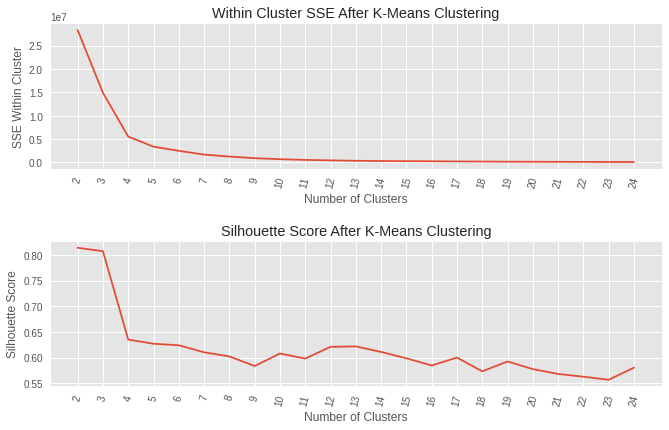

In [528]:
plot_cluster(large_medium_sub, features, max_loop=25)

clustering performance
-----------------------------------
silhouette score: 0.63
sse withing cluster: 5550640.0


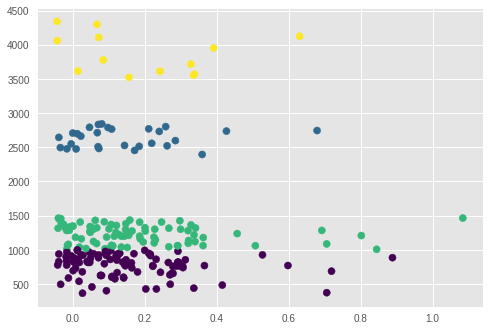

In [529]:
third_iteration = apply_cluster(large_medium_sub, features, 4)

In [530]:
cluster_perf_df = (
    third_iteration
    .groupby('cluster')
    .agg({"roi":"mean", "bathrooms":"mean", "zip_code": "count", "bedrooms":"mean", "area_numeric":"mean", "school":"mean"})
    .sort_values('roi')
    .reset_index()
)

cluster_perf_df

,cluster,roi,bathrooms,zip_code,bedrooms,area_numeric,school
0,1,0.142910,2.821429,28,3.642857,2635.607143,5.035714
1,0,0.157021,1.193878,98,1.408163,775.846939,4.785714
2,2,0.181423,1.843373,83,2.481928,1232.674699,4.542169
3,3,0.197834,3.692308,13,4.538462,3865.076923,4.923077


In [535]:
small_sub = large_medium_sub.query("cluster == 3 or cluster == 2").reset_index(drop=True)
small_sub.shape

(96, 9)

### Iteration 4

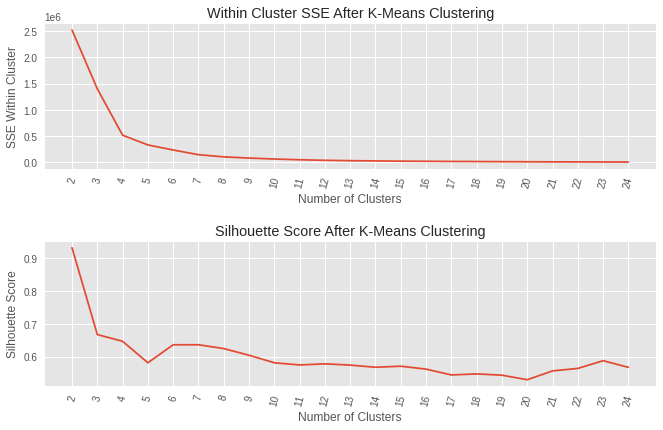

In [536]:
plot_cluster(small_sub, features, max_loop=25)

clustering performance
-----------------------------------
silhouette score: 0.64
sse withing cluster: 235687.0


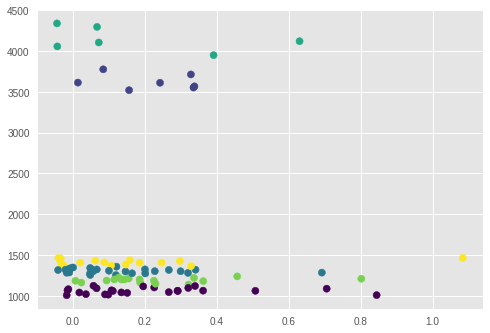

In [538]:
forth_iteration = apply_cluster(small_sub, features, 6)

In [539]:
cluster_perf_df = (
    forth_iteration
    .groupby('cluster')
    .agg({"roi":"mean", "bathrooms":"mean", "zip_code": "count", "bedrooms":"mean", "area_numeric":"mean", "school":"mean"})
    .sort_values('roi')
    .reset_index()
)

cluster_perf_df

,cluster,roi,bathrooms,zip_code,bedrooms,area_numeric,school
0,2,0.131512,2.000000,26,2.500000,1305.346154,4.423077
1,5,0.159670,2.062500,16,2.687500,1415.312500,4.000000
2,3,0.178892,3.833333,6,4.500000,4146.666667,6.166667
3,1,0.214070,3.571429,7,4.571429,3623.714286,3.857143
4,0,0.215657,1.458333,24,2.375000,1061.708333,4.833333
5,4,0.229900,1.941176,17,2.411765,1191.000000,4.823529


In [541]:
third_iteration.query("cluster == 4").zip_code.unique().to_list()

[80202,
 80203,
 80206,
 80210,
 80204,
 80209,
 80212,
 80216,
 80218,
 80220,
 80223,
 80231,
 80207]

**Golder Cluster** is number 4 and the inverstor should pay attention to the mentioned above zipcodes

# Muller Loop

In [568]:
denver_data8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 600
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   bathrooms       597 non-null    float64 
 1   bedrooms        597 non-null    float64 
 2   listing_type    597 non-null    category
 3   area_numeric    597 non-null    float64 
 4   price_per_sqft  597 non-null    float64 
 5   zip_code        597 non-null    category
 6   school          597 non-null    category
 7   roi             597 non-null    float64 
dtypes: category(3), float64(5)
memory usage: 51.8 KB


In [569]:

denver_data9 = denver_data8.drop(['price_per_sqft', 'school', 'listing_type'], axis=1).copy()
dummies_zip = pd.get_dummies(denver_data9.zip_code)


In [570]:
denver_data10 = pd.concat([denver_data9,dummies_zip],axis='columns').drop(['zip_code'], axis=1)
denver_data10.head(2)

,bathrooms,bedrooms,area_numeric,roi,80123,80202,80203,80204,80205,80206,80207,80209,80210,80211,80212,80214,80216,80218,80219,80220,80221,80222,80223,80224,80227,80230,80231,80236,80237,80238,80239,80246,80247,80249
0,1.0,0.0,485.0,0.415416,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,402.0,0.093249,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [576]:
X = denver_data10.drop(['roi'], axis=1).copy()
y = denver_data10.roi

In [577]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [670]:
denver_data6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 600
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   property_id      597 non-null    int64   
 1   address          597 non-null    object  
 2   latitude         597 non-null    float64 
 3   longitude        597 non-null    float64 
 4   price            597 non-null    int64   
 5   bathrooms        597 non-null    float64 
 6   bedrooms         597 non-null    float64 
 7   rent_zestimate   597 non-null    float64 
 8   listing_type     597 non-null    category
 9   property_url     597 non-null    object  
 10  area_numeric     597 non-null    float64 
 11  price_per_sqft   597 non-null    float64 
 12  zip_code         597 non-null    int64   
 13  hoa              597 non-null    object  
 14  lot_area         597 non-null    int64   
 15  school           597 non-null    category
 16  hoa_amount       597 non-null    int64   
 1

In [677]:
X_class = denver_data6.drop(['zip_code', 'hoa', 'hoa_period', 'property_id', 'address', 'latitude', 'longitude', 'rent_zestimate', 'listing_type', 'property_url', 'price_per_sqft', 'profit', 'roi', 'price', 'lot_unit', 'lot_multiplier'], axis=1).copy()
X_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 600
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   bathrooms        597 non-null    float64 
 1   bedrooms         597 non-null    float64 
 2   area_numeric     597 non-null    float64 
 3   lot_area         597 non-null    int64   
 4   school           597 non-null    category
 5   hoa_amount       597 non-null    int64   
 6   mortgage_amount  597 non-null    float64 
dtypes: category(1), float64(4), int64(2)
memory usage: 53.6 KB


In [678]:
y_class=denver_data6.profit.astype('int')

## Classification

In [679]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [680]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier()
    ]

Xcl = StandardScaler().fit_transform(X_class)
Xcl_train, Xcl_test, ycl_train, ycl_test = \
    train_test_split(Xcl, y_class, test_size=.2)

max_score = 0.0
max_class = ''

In [681]:
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(Xcl_train, ycl_train)
    score = 100.0 * clf.score(Xcl_test, ycl_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

Classifier = Nearest Neighbors, Score (test, accuracy) = 0.83, Training time = 0.01 seconds
Classifier = Linear SVM, Score (test, accuracy) = 0.00, Training time = 0.29 seconds
Classifier = RBF SVM, Score (test, accuracy) = 0.83, Training time = 0.32 seconds
Classifier = Decision Tree, Score (test, accuracy) = 0.00, Training time = 0.01 seconds
Classifier = Random Forest, Score (test, accuracy) = 0.83, Training time = 0.03 seconds
Classifier = Neural Net, Score (test, accuracy) = 0.00, Training time = 20.74 seconds
Classifier = AdaBoost, Score (test, accuracy) = 0.00, Training time = 0.72 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Nearest Neighbors, Score (test, accuracy) = 0.83


For profit prediction Nearest Neighbors Classifier demonstrated the best result

## Regressors

In [542]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

In [560]:
regressors = []
regressors.append(('Dummy Regressor', DummyRegressor()))
regressors.append(('Linear Regression', LinearRegression()))
regressors.append(('KNN Regression', KNeighborsRegressor(n_neighbors=2, weights='uniform')))
regressors.append(('Random Forest Regression', RandomForestRegressor(n_estimators = 500, random_state = 102)))
regressors.append(('Decision Tree Regression', DecisionTreeRegressor(random_state=1)))
regressors.append(('AdaBoost Regression', AdaBoostRegressor(n_estimators=50, random_state=None)))
regressors.append(('XGBoost Regression', XGBRegressor(verbosity=0, n_estimators =500)))

In [578]:
results = []
predictions = []
for name, regressor in regressors:
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  r2 = metrics.r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  scores = regressor.score(X_test, y_test)
  results.append([name, r2, mse, mae, rmse, scores])
  predictions.append([name, y_pred])

df_regressions = pd.DataFrame(results, columns=['Name', 'R2 Score', 'MSE', 'MAE', 'RMSE', 'score'])
df_predictions = pd.DataFrame(predictions, columns = ['Name', 'Predictions'])

df_regressions

,Name,R2 Score,MSE,MAE,RMSE,score
0,Dummy Regressor,-0.016140,0.044982,0.159859,0.212089,-0.016140
1,Linear Regression,0.288565,0.031493,0.131270,0.177464,0.288565
2,KNN Regression,-0.412758,0.062539,0.195006,0.250078,-0.412758
3,Random Forest Regression,0.194109,0.035675,0.134257,0.188877,0.194109
4,Decision Tree Regression,-0.506789,0.066702,0.189671,0.258267,-0.506789
5,AdaBoost Regression,0.019383,0.043409,0.155633,0.208349,0.019383
6,XGBoost Regression,0.168556,0.036806,0.142343,0.191849,0.168556


According to the result the best score is score gives Linear Regression, we will use it for the model

In [579]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.31768814, 0.33083558, 0.2226501 , 0.26452804, 0.26221906])

# Model Export

In [583]:
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.2885649605123257

In [590]:
np.where(X.columns == 80202)[0][0]

4

In [598]:
def predict_roi(zip,sqft,bath,bed):
        
    loc_index = np.where(X.columns==zip)[0][0]

    x = np.zeros(len(X.columns))
    x[2] = sqft
    x[0] = bath
    x[1] = bed
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [599]:
predict_roi(80203,800, 3, 6)

-0.12365539932447933

In [604]:
import pickle
with open('midterm_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [605]:
import json
columns = {
    'data_columns' : [col for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

# References

*   [Data scraping. Novice](https://www.freecodecamp.org/news/web-scraping-python-tutorial-how-to-scrape-data-from-a-website/)  
*   [Data scraping. Inter](https://blog.devgenius.io/scraping-zillow-with-python-and-beautifulsoup-bbc7e581c218)
* [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#calling-a-tag-is-like-calling-find-all)
* [Columns Creations with Pandas](https://towardsdatascience.com/the-ultimate-guide-for-column-creation-with-pandas-dataframes-83b8c565110e)
* [Data Science Regression Project: Predicting Home Prices in Banglore
](https://github.com/codebasics/py/blob/master/DataScience/BangloreHomePrices/model/banglore_home_prices_final.ipynb)
* [Mortgage calculator](https://medium.com/swlh/simple-mortgage-calculator-with-python-and-excel-b98dede36720) 
* [Feature overview method](https://www.kaggle.com/lildatascientist/eda-auto-ml-house-prices#MSSubClass)

* [Machine Learning Pocket Reference by Matt Harrison](https://learning.oreilly.com/library/view/machine-learning-pocket)

* [Feature Selection with categorical data](https://machinelearningmastery.com/feature-selection-with-categorical-data/)

* [Clustering](https://github.com/ttimong/blog-posts/blob/master/blog1-kmeans-clustering/final_model.ipynb)

* [Muller Loop for classification](https://github.com/aarsanjani/applied-ml-2020/blob/master/MullerLoop.ipynb)
